In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style
import seaborn as sns

import plotly.express as px

import hbsir

matplotlib.style.use("bmh")

In [2]:
year = 1395

df = pd.concat(
    [
        hbsir.load_table("Total_Expenditure", years=year).set_index(["Year", "ID"]),
        hbsir.load_table("Total_Income", years=year).set_index(["Year", "ID"]),
        hbsir.load_table("Equivalence_Scale", years=year).set_index(["Year", "ID"]),
    ],
    axis="columns",
)
columns = ["Gross_Expenditure", "Net_Expenditure", "Income"]

df[columns] = df[columns].divide(df["OECD_Modified"], axis="index")

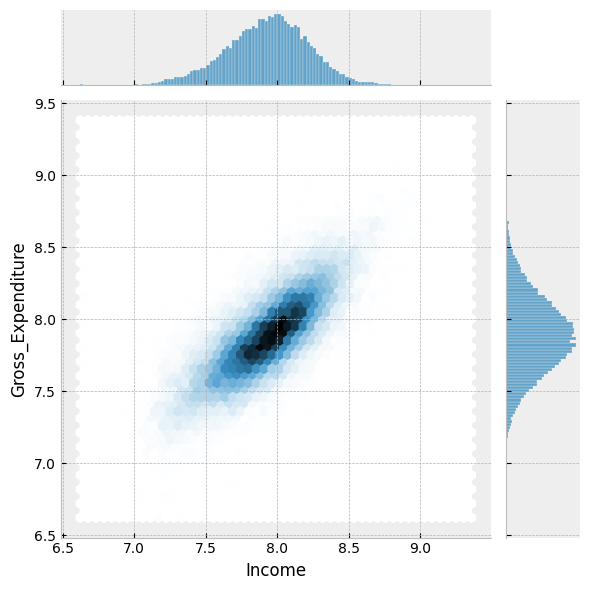

In [3]:
sns.jointplot(df[["Income", "Gross_Expenditure"]].clip(4.2e6, 1e10).map(np.log10), x="Income", y="Gross_Expenditure", kind="hex")

In [4]:
def build_columns_tuples(dataframe: pd.DataFrame, columns: list) -> list[tuple]:
    return list(zip(*[dataframe[column] for column in columns]))


def build_columns_series(
        dataframe: pd.DataFrame,
        columns: list,
        index: tuple = ("Year", "ID", "Member_Number")
) -> pd.Series:
    return pd.Series(
        data=build_columns_tuples(dataframe, columns),
        index=pd.MultiIndex.from_frame(dataframe[list(index)])
    )

YEARS = range(1389, 1401)

members = (
    hbsir.load_table("members_properties", years=YEARS)
    .dropna(subset="Member_Number")
    .assign(Member_Number=lambda df: df["Member_Number"].astype(int))
)

columns = ["Year", "ID", "Relationship", "Sex", "Age", "Marrital_State"]

lead_df = (
    pd.concat(
        [
            members,
            members.eval("Age = Age + 1"),
        ]
    )
    .eval("Year = Year + 1")
)

lead_set = build_columns_tuples(lead_df, columns)
same_members_lead = build_columns_series(members, columns).isin(lead_set)

lag_df = (
    pd.concat(
        [
            members,
            members.eval("Age = Age - 1"),
        ]
    )
)

lag_set = build_columns_tuples(lag_df, columns)
same_members_lag = (
    build_columns_series(members.eval("Year = Year + 1"), columns).isin(lag_set)
)

member_filter = (
    (same_members_lead & same_members_lag)
    .groupby(["Year", "ID"]).all()
)

member_filter.groupby("Year").sum()

Year
1389       0
1390    8239
1391    9205
1392       0
1393    6671
1394    7452
1395    7584
1396    7319
1397       0
1398    7118
1399    8726
1400    8715
1401       0
dtype: int64

In [5]:
year = 1396
panel_households = (
    member_filter
    .loc[member_filter].loc[year]
    .index
)

In [6]:
expenditure_table = hbsir.load_table("Total_Income", years=[year-1, year])
filt = expenditure_table["ID"].isin(panel_households)
income_panel = (
    expenditure_table.loc[filt]
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .query("Urban_Rural=='Urban'")
    .merge(hbsir.load_table("household_information", years=[year-1, year]), on=["Year", "ID"], validate="1:1")
    .merge(
        hbsir.external_data.load_table("cpi_1395", data_source="SCI",frequency="Monthly", separate_by="Urban_Rural"),
        on=["Year", "Month", "Urban_Rural"], validate="m:1"
    )
    .assign(Expenditure=lambda df: df.eval("Income / CPI * 100 / 1e7"))
    .set_index(["Year", "ID"])
    .loc[:, "Income"]
    .unstack(0)
)

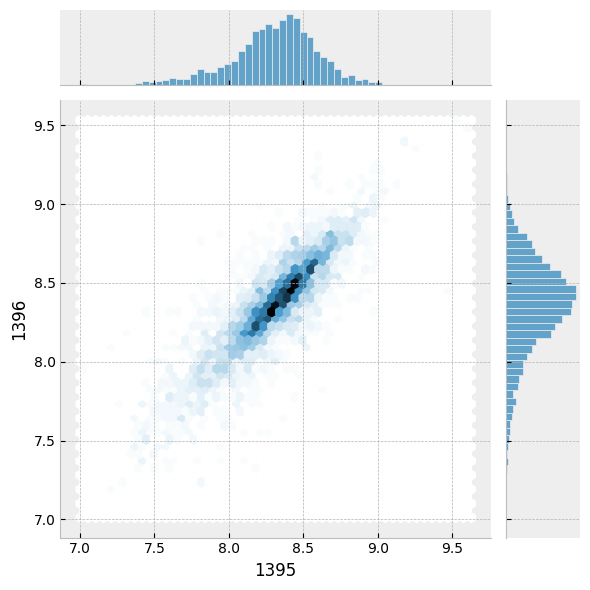

In [7]:
ax = sns.jointplot(income_panel.clip(1e7).map(np.log10), x=year-1, y=year, kind="hex")

<Axes: ylabel='Count'>

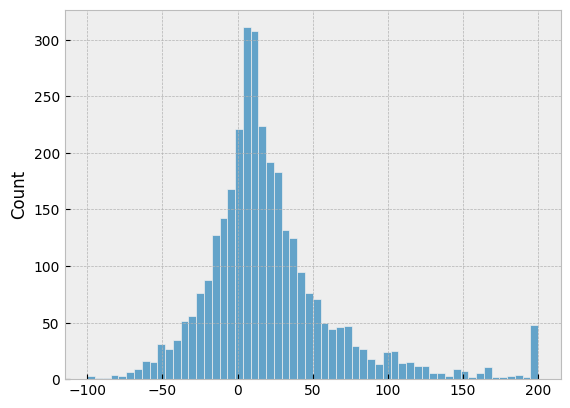

In [8]:
diff = income_panel[year].subtract(income_panel[year-1]).divide(income_panel[year-1]).multiply(100)
sns.histplot(diff.clip(-100, 200))

Text(0.5, 1.0, 'Percentage Change in Income from 1395 to 1396')

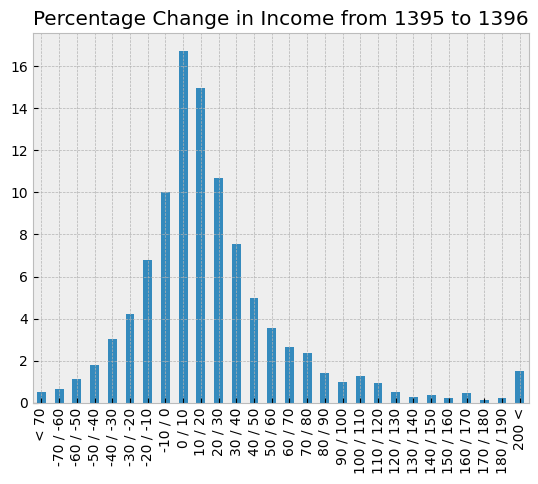

In [9]:
ax = (
    pd.cut(
        diff,
        bins=[-np.inf] + list(range(-70, 191, 10)) + [np.inf],
        labels=["< 70"] + [f"{percent} / {percent+10}" for percent in range(-70, 190, 10)] + ["200 <"],
    )
    .value_counts()
    .sort_index()
    .divide(len(diff.index))
    .multiply(100)
    .plot.bar()
)
ax.set_title("Percentage Change in Income from 1395 to 1396")